In [105]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
from sklearn.metrics import  roc_auc_score, auc
from sklearn.metrics import precision_score, recall_score

plt.style.use('cyberpunk')

#Downloading the dataset

In [107]:
df = pd.read_csv("course_lead_scoring.csv")
df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


Data preparation
Check if the missing values are presented in the features.
If there are missing values:
For caterogiral features, replace them with 'NA'
For numerical features, replace with with 0.0
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

# Check for missing values in df.

In [110]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Data preparation Check if the missing values are presented in the features. If there are missing values: For caterogiral features, replace them with 'NA' For numerical features, replace with with 0.0

In [112]:
df = df.fillna({col: 'NA' if df[col].dtype == 'object' else 0.0 for col in df.columns})

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [114]:
# Split 60% train, 40% temp (which we'll later split into 20% val, 20% test)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=1)

# Split the 40% temp into 20% val and 20% test (each 50% of the temp data)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1)

# Print the shapes to verify the split
print("Training set:", train_df.shape)
print("Validation set:", val_df.shape)
print("Test set:", test_df.shape)

Training set: (877, 9)
Validation set: (292, 9)
Test set: (293, 9)


Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

lead_score
number_of_courses_viewed
interaction_count
annual_income

In [116]:
y = train_df['converted'].astype(int).values  # ensure 1D numpy array
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for col in num_vars:
    # Make sure feature column is numeric 1D array
    x = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(float).values

    # Check that both y and x are 1D arrays of same length
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError(f"{col} or y is not 1D: x.shape={x.shape}, y.shape={y.shape}")
    if len(x) != len(y):
        raise ValueError(f"Length mismatch: len(x)={len(x)}, len(y)={len(y)}")

    # Compute AUC
    auc = roc_auc_score(y, x)

    # Invert if AUC < 0.5
    if auc < 0.5:
        x = -x
        auc = roc_auc_score(y, x)
        print(f"Inverted {col} due to negative correlation.")

    auc_scores[col] = auc

# Display results
print("\nAUC Scores:")
for col, score in auc_scores.items():
    print(f"{col}: {score:.4f}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\n🏆 Highest AUC Feature: {best_feature}")


AUC Scores:
lead_score: 0.6111
number_of_courses_viewed: 0.7652
interaction_count: 0.7272
annual_income: 0.5446

🏆 Highest AUC Feature: number_of_courses_viewed


Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.32
0.52
0.72
0.92

In [118]:


# Prepare the data ---
# Define target column
target = 'converted'

# Separate target from features
y_train = train_df[target].astype(int).values
y_val = val_df[target].astype(int).values

X_train = train_df.drop(columns=[target])
X_val = val_df.drop(columns=[target])

#  One-hot encoding using DictVectorizer ---
# Convert DataFrame to a list of dictionaries (for DictVectorizer)
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# Initialize and fit the vectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

#  Train Logistic Regression model ---
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Evaluate model ---
y_pred_val = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_pred_val)

print(f"\nAUC on validation set: {auc:.3f}")



AUC on validation set: 0.794


Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145
0.345
0.545
0.745

C:\Users\rinim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\rinim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


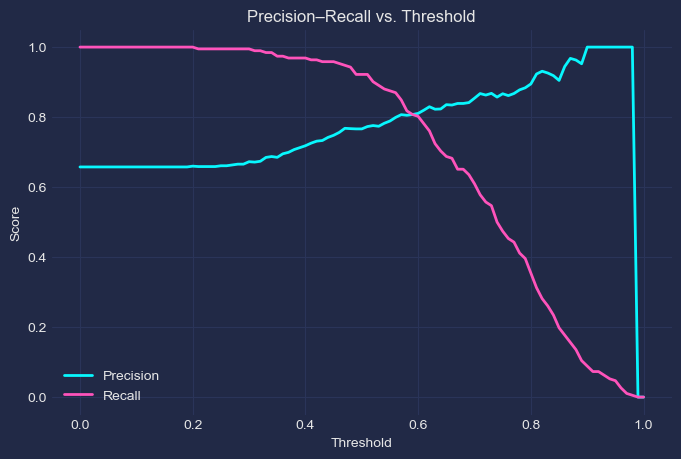


Precision and Recall intersect around threshold: 0.590


In [120]:


# Get prediction probabilities from  trained model ---
y_scores = model.predict_proba(X_val_encoded)[:, 1]
y_true = y_val

#  Evaluate across thresholds ---
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))

#  Plot Precision and Recall ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find intersection threshold ---
# Compute absolute difference between precision and recall at each threshold
diff = np.abs(np.array(precisions) - np.array(recalls))
best_idx = np.argmin(diff)
intersection_threshold = thresholds[best_idx]

print(f"\nPrecision and Recall intersect around threshold: {intersection_threshold:.3f}")


In [121]:
from sklearn.metrics import precision_score, recall_score

Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F
1
=
2
⋅
P
⋅
R
P
+
R

Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.14
0.34
0.54
0.74

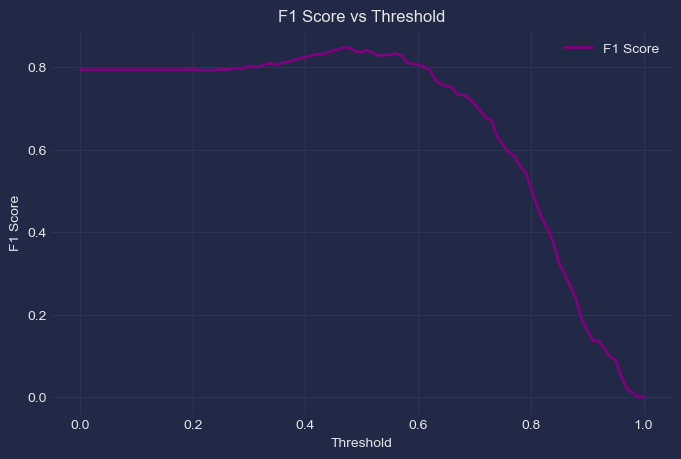


✅ Maximum F1 = 0.848 at threshold = 0.470


In [122]:


# Compute precision & recall across thresholds ---
thresholds = np.arange(0.0, 1.01, 0.01)
precisions, recalls, f1_scores = [], [], []

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred)
    precisions.append(p)
    recalls.append(r)
    # Compute F1 score safely
    f1 = 0 if (p + r) == 0 else 2 * p * r / (p + r)
    f1_scores.append(f1)

# Plot F1 vs threshold ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Find the threshold with maximum F1 ---
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n✅ Maximum F1 = {best_f1:.3f} at threshold = {best_threshold:.3f}")


Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.36

In [124]:

from sklearn.feature_extraction import DictVectorizer

# Prepare data ---
df_full_train = pd.concat([train_df, val_df])  # Combine train + val for full training data
y_full = df_full_train['converted'].astype(int).values
df_full = df_full_train.drop(columns=['converted'])

#  Initialize KFold ---
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUCs for each fold ---
aucs = []

for train_idx, val_idx in kf.split(df_full):
    # Split data
    df_train = df_full.iloc[train_idx]
    df_val = df_full.iloc[val_idx]
    y_train = y_full[train_idx]
    y_val = y_full[val_idx]

    # One-hot encode using DictVectorizer
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))

    # Train logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

    print(f"Fold AUC: {auc:.3f}")

#  Calculate mean & std deviation ---
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

print(f"\nMean AUC across folds: {mean_auc:.3f}")
print(f"Standard deviation of AUC: {std_auc:.3f}")




Fold AUC: 0.807
Fold AUC: 0.807
Fold AUC: 0.865
Fold AUC: 0.833
Fold AUC: 0.815

Mean AUC across folds: 0.825
Standard deviation of AUC: 0.022


Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001
0.001
1
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [126]:


# Prepare data ---
df_full_train = pd.concat([train_df, val_df])
y_full = df_full_train['converted'].astype(int).values
df_full = df_full_train.drop(columns=['converted'])

# Initialize KFold ---
kf = KFold(n_splits=5, shuffle=True, random_state=1)

#  Candidate C values ---
C_values = [0.000001, 0.001, 1]
results = []

#  Evaluate each C using 5-fold CV ---
for C in C_values:
    aucs = []
    
    for train_idx, val_idx in kf.split(df_full):
        # Split folds
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[val_idx]
        y_train = y_full[train_idx]
        y_val = y_full[val_idx]

        # One-hot encode using DictVectorizer
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val = dv.transform(df_val.to_dict(orient='records'))

        # Train model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Evaluate on validation
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    # Compute mean & std
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    results.append((C, round(mean_auc, 3), round(std_auc, 3)))
    print(f"C={C} -> Mean AUC={mean_auc:.3f}, Std={std_auc:.3f}")

# Select best C ---
results_df = pd.DataFrame(results, columns=['C', 'Mean_AUC', 'Std_AUC'])
best_row = results_df.sort_values(['Mean_AUC', 'Std_AUC', 'C'], ascending=[False, True, True]).iloc[0]

print("\nCross-validation results:")
print(results_df)
print(f"\n🏆 Best parameter: C={best_row.C}, Mean AUC={best_row.Mean_AUC}, Std={best_row.Std_AUC}")


C=1e-06 -> Mean AUC=0.543, Std=0.025
C=0.001 -> Mean AUC=0.864, Std=0.014
C=1 -> Mean AUC=0.825, Std=0.022

Cross-validation results:
          C  Mean_AUC  Std_AUC
0  0.000001     0.543    0.025
1  0.001000     0.864    0.014
2  1.000000     0.825    0.022

🏆 Best parameter: C=0.001, Mean AUC=0.864, Std=0.014
